# Correlation Analysis

In [103]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

In [97]:
## Import the Data
adata = sc.read_h5ad("/Users/olyssa/PycharmProjects/VAE_embeddings/PBMC_adata.h5ad")

embedding = adata.obsm['embedding']

#Checking if cells are sorted the same in embedding table and X table for correlation analysis
print((adata.obs_names == adata.obs.index).all())  # Has to be "TRUE"

True


## Correlations between embedding features and gene expression levels

In [98]:
# Import data from correlation computations
spearman_corr = pd.read_csv("corals_spearman_pvalues_results.csv")
spearman_corr.shape

(268620, 4)

In [99]:
# Filter for p-value <= 0.001 AND abs(spearman_correlation) >= 0.3
import numpy as np
spearman_corr_filtered = spearman_corr[(spearman_corr["P_Value"]<=0.001) & (np.abs(spearman_corr["Spearman_Correlation"])>=0.3)]
spearman_corr_filtered.shape

(1484, 4)

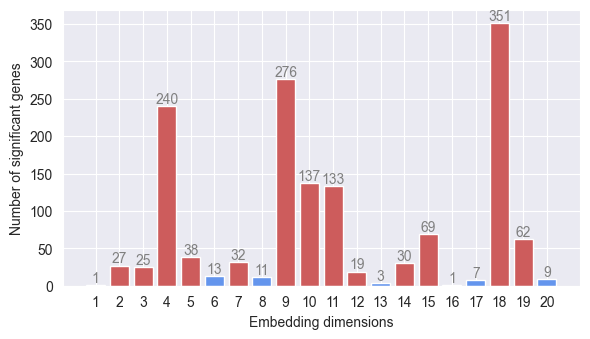

In [100]:
# Histogram to plot number of significant genes per embedding dimension
gene_counts = spearman_corr_filtered.groupby("Embedding_Feature")["Gene"].count().reset_index()
gene_counts.columns = ["embedding_feature", "gene_count"]
colors = ["indianred" if count >= 15 else "cornflowerblue" for count in gene_counts["gene_count"]]

fig, axes = plt.subplots(figsize=(6, 3.5))
bars = plt.bar(gene_counts["embedding_feature"]+1, gene_counts["gene_count"], color=colors)
for bar in bars:
    height = bar.get_height()  # Get bar height
    plt.text(bar.get_x() + bar.get_width()/2, height,  
             f"{int(height)}", ha='center', va='bottom', fontsize=10, c="grey")
plt.xticks(range(1, 21))  
plt.xlabel("Embedding dimensions")
plt.ylabel("Number of significant genes")
plt.tight_layout()
fig.savefig('significant_genes_per_dimension.png', dpi=200)
plt.show()

## Correlations between embedding features and sample batches

### Kruskal-Wallis

In [3]:
# Define batch categories
groups = ["site", "donor"]

In [101]:
# Define embedding space
embedding = adata.obsm["embedding"]
embedding = pd.DataFrame(embedding)

num_embedding_dims = embedding.shape[1]

# Store as dataframe
for group in groups:
    embedding[f"{group}"] = adata.obs[group].values

In [ ]:
# Define Kruskal-Wallis
def kruskal_wallis(group):
    # Get unique batch categories
    batch_categories = embedding[f"{group}"].unique()
    
    # Compute Kruskal-Wallis p-values (dimensions × batches)
    kruskal_pvalues = np.zeros((num_embedding_dims, len(batch_categories)))
    
    for dim_idx, dim in enumerate(embedding.columns[:-3]):  # Exclude batch column
        for batch_idx, batch in enumerate(batch_categories):
            # Split data into current batch vs. all other batches
            group1 = embedding[embedding[f"{group}"] == batch][dim]
            group2 = embedding[embedding[f"{group}"] != batch][dim]
            
            # Compute Kruskal-Wallis test
            stat, p_value = kruskal(group1, group2)
            kruskal_pvalues[dim_idx, batch_idx] = p_value  # Store p-value
    
    # Convert to DataFrame
    kruskal_df = pd.DataFrame(kruskal_pvalues, 
                              index=[f"{i+1}" for i in range(num_embedding_dims)], 
                              columns=batch_categories)
    
    return kruskal_df

In [102]:
# Iterate over batch categories
kruskel_df_list = []
for i in range(len(groups)):
    kruskel_df_list.append(kruskal_wallis(groups[i]))

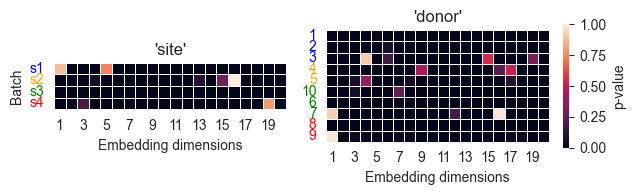

In [105]:
# Visualize correlations

site_colors = ["blue", "orange", "green", "red"]
donor_colors = ["blue", "blue", "blue", "orange", "orange", "green", "green", "green", "red", "red"]

fig, axes = plt.subplots(1, 2, figsize=(6.5,2), gridspec_kw={"width_ratios": [1, 1.2]})

# site
sns.heatmap(kruskel_df_list[0].T, ax=axes[0], cmap="rocket", linewidths=0.5, square=True, cbar=False)
axes[0].set_ylabel("Batch")
i = 0
for tick in axes[0].get_yticklabels():
    tick.set_color(site_colors[i])
    i += 1

# donor
sns.heatmap(kruskel_df_list[1].T, ax=axes[1], cmap="rocket", linewidths=0.5, square=True, cbar=True, vmin=0, vmax=1, cbar_kws={"shrink": 0.8, "label": "p-value"})
axes[1].set_title(f"'{groups[1]}'")
axes[1].set_xlabel("Embedding dimensions")
i = 0
for tick in axes[1].get_yticklabels():
    tick.set_color(donor_colors[i])
    i += 1

for i in range(len(groups)-1):
    axes[i].set_title(f"'{groups[i]}'")
    axes[i].set_xlabel("Embedding dimensions")
    axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
fig.savefig('correlation_embedding_batches.png', dpi=200)
plt.show()

### Random forest
another neat things you could do would be to train a random forest classifier on embedding values to predict any of the cell metadata (site, donor, etc). Random forest then can return you very clean feature importances -> say, which input dimention was the most informative. I would recommend you to run it. It is easy and fast to use with sklearn and it can uncover some interesting relationships. for implementation check this

In [106]:
from sklearn.model_selection import train_test_split
random_seed = 91

# Define data 
def define_data(group):
    embedding = adata.obsm["embedding"]
    embedding = pd.DataFrame(embedding)
    
    # Remove predictor variables with a low variation across samples
    column_sds = np.std(embedding, axis=1)
    filtered_cells = column_sds > 0.08
    embedding_filtered = embedding[filtered_cells==True]
    
    embedding_filtered[f"{group}"] = adata.obs[group].values[filtered_cells==True]
    embedding_sample = embedding_filtered.sample(frac=1)
    
    # Splitting data into 90 % training and 10 % testing
    training, testing = train_test_split(embedding_sample, 
                                         test_size=0.1, 
                                         random_state=random_seed
                                         )
    
    # Define the feature set (X) and target variable (y) of training set
    X_train = training.iloc[:, :-1]  # Features
    y_train = training[group]  # Target variable (continuous)
    
    # Define the feature set (X) and target variable (y) of testing set
    X_test = testing.iloc[:, :-1]  # Features
    y_test = testing[group]  # Target variable (continuous)
    
    # Encode categorical target variable
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)  # Convert categorical target to numeric labels
    y_test_encoded = le.transform(y_test)
    
    return X_train, X_test, y_train_encoded, y_test_encoded, le

In [107]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=random_seed)

# Define model performance assessment
def rf_training_validation(group):
    
    X_train, X_test, y_train_encoded, y_test_encoded, le = define_data(group)
    
    ### Define cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    
    # Cross-validation results
    print('\033[1m' + "Cross-validation results:")
    accuracy_scores = cross_val_score(rf_model, X_train, y_train_encoded, cv=cv, scoring='accuracy')
    print('\033[0m' + f"Accuracy scores across folds: {accuracy_scores}")
    print(f"Mean Accuracy: {accuracy_scores.mean():.3f}")
    print(f"Standard Deviation of Accuracy: {accuracy_scores.std():.3f}")
    
    # Train the model on the entire training set
    rf_model.fit(X_train, y_train_encoded)
    
    ### Testing the model on the testing set
    
    # Predict on the test data
    y_pred_encoded = rf_model.predict(X_test)
    
    # Convert predictions back to original categories
    #y_pred = le.inverse_transform(y_pred_encoded)
    
    # Calculate Accuracy on the test set
    accuracy_test_rf = accuracy_score(y_test_encoded, y_pred_encoded)
    print('\n \033[1m' + "Model performance tested on the testing set:")
    print('\033[0m' + f"Accuracy: {accuracy_test_rf:.3f}")
    
    return rf_model, y_pred_encoded, X_test, y_test_encoded, le

In [108]:
from sklearn.metrics import confusion_matrix

# Define plotting confusion matrix
def plot_confusion_matrix(group):
    
    rf_model, y_pred_encoded, X_test, y_test_encoded, le = rf_training_validation(group)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred_encoded)
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Random Forest: Confusion Matrix")
    plt.show()

In [109]:
from sklearn.inspection import permutation_importance

# Define permutation importance measure
def perm_importance_rf(group):
    
    rf_model, y_pred_encoded, X_test, y_test_encoded, le = rf_training_validation(group)
    
    perm_importance_rf = permutation_importance(
        rf_model, X_test, y_test_encoded,  
        scoring='accuracy',  
        n_repeats=100,
        random_state=random_seed
    )
    
    # Create a DataFrame for feature importance
    perm_df_rf = pd.DataFrame({
        'Feature': X_test.columns,  # Use actual feature names
        'Importance': perm_importance_rf.importances_mean
    })
    
    # Sort by importance
    perm_df_rf = perm_df_rf.sort_values(by='Importance', ascending=False)
    
    return perm_df_rf

/var/folders/2v/_c7y979j6tjczs_z_jz_fjyw0000gn/T/ipykernel_93864/3548933616.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding_filtered[f"{group}"] = adata.obs[group].values[filtered_cells==True]


Cross-validation results:
Accuracy scores across folds: [0.63001486 0.65230312 0.60326895 0.62797619 0.60416667]
Mean Accuracy: 0.624
Standard Deviation of Accuracy: 0.018

 Model performance tested on the testing set:
Accuracy: 0.634
Cross-validation results:


/var/folders/2v/_c7y979j6tjczs_z_jz_fjyw0000gn/T/ipykernel_93864/3548933616.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding_filtered[f"{group}"] = adata.obs[group].values[filtered_cells==True]


Accuracy scores across folds: [0.49628529 0.47845468 0.4858841  0.48809524 0.49553571]
Mean Accuracy: 0.489
Standard Deviation of Accuracy: 0.007

 Model performance tested on the testing set:
Accuracy: 0.492


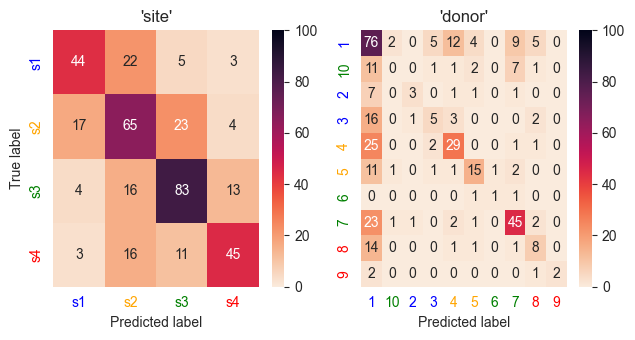

In [110]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(6.5, 3.5))

for i in range(len(groups)):
    rf_model, y_pred_encoded, X_test, y_test_encoded, le = rf_training_validation(groups[i])
    cm = confusion_matrix(y_test_encoded, y_pred_encoded)
    sns.heatmap(cm, ax=axes[i], annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, vmin=0, vmax=100, cmap='rocket_r')
    
    axes[i].set_title(f"'{groups[i]}'")
    axes[i].set_xlabel("Predicted label")

site_colors = ["blue", "orange", "green", "red"]
donor_colors = ["blue", "green", "blue", "blue", "orange", "orange", "green", "green", "red", "red"]
i = 0
for tick in axes[0].get_yticklabels():
    tick.set_color(site_colors[i])
    i += 1
i = 0
for tick in axes[1].get_yticklabels():
    tick.set_color(donor_colors[i])
    i += 1
i = 0
for tick in axes[0].get_xticklabels():
    tick.set_color(site_colors[i])
    i += 1
i = 0
for tick in axes[1].get_xticklabels():
    tick.set_color(donor_colors[i])
    i += 1
    
axes[0].set_ylabel("True label")
plt.tight_layout()
fig.savefig('confusion_matrix.png', dpi=200)
plt.show()

In [111]:
perm_df_rf_list = []
for i in range(len(groups)):
    perm_df_rf_list.append(perm_importance_rf(groups[i]))

/var/folders/2v/_c7y979j6tjczs_z_jz_fjyw0000gn/T/ipykernel_93864/3548933616.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding_filtered[f"{group}"] = adata.obs[group].values[filtered_cells==True]


Cross-validation results:
Accuracy scores across folds: [0.59732541 0.62852897 0.63893016 0.64136905 0.60119048]
Mean Accuracy: 0.621
Standard Deviation of Accuracy: 0.019

 Model performance tested on the testing set:
Accuracy: 0.676


/var/folders/2v/_c7y979j6tjczs_z_jz_fjyw0000gn/T/ipykernel_93864/3548933616.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding_filtered[f"{group}"] = adata.obs[group].values[filtered_cells==True]


Cross-validation results:
Accuracy scores across folds: [0.50371471 0.50074294 0.4769688  0.47916667 0.50595238]
Mean Accuracy: 0.493
Standard Deviation of Accuracy: 0.013

 Model performance tested on the testing set:
Accuracy: 0.503


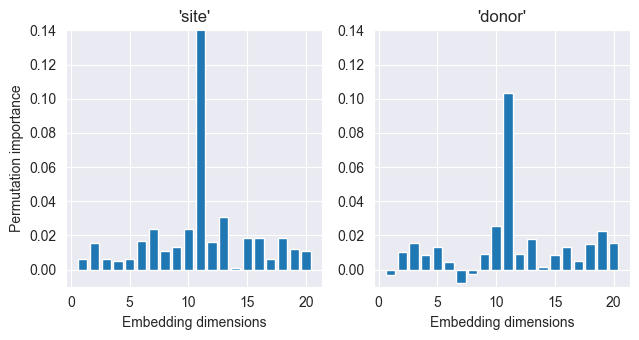

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(6.5, 3.5))

#fig.suptitle("Variable importance of Random Forest model", fontsize=16)

for i in range(len(groups)):
    perm_df_rf = perm_df_rf_list[i]
    axes[i].bar(perm_df_rf['Feature']+1, perm_df_rf['Importance'])
    axes[i].set_title(f"'{groups[i]}'")
    axes[i].set_xlabel("Embedding dimensions")
    #axes[i].set_xticks(range(1, 21))
    axes[i].set_ylim(-0.01, 0.14)

axes[0].set_ylabel("Permutation importance")
plt.tight_layout()

fig.savefig('variable_importance.png', dpi=200)
plt.show()